# Autocodificadores

- Conceito de auto-supervisionado
- Conceito de embedding de uma imagem
- Rede geradora de imagens

<table align='left'>
<tr><td> <img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/autoencoder_schema.jpg"> </td></tr>
</table>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np

from PIL import Image
from IPython import display

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST

In [ ]:
!pip install pytorch-lightning
import pytorch_lightning as pl

     |████████████████████████████████| 849kB 8.4MB/s 
     |████████████████████████████████| 184kB 18.1MB/s 
     |████████████████████████████████| 112kB 13.5MB/s 
     |████████████████████████████████| 276kB 16.6MB/s 
     |████████████████████████████████| 829kB 23.0MB/s 
     |████████████████████████████████| 1.3MB 50.0MB/s 
     |████████████████████████████████| 296kB 51.3MB/s 
     |████████████████████████████████| 143kB 54.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=729682ded749a9341d3aa4e87d1d56081377c036a057dadd7fc998e25b7fbacf
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=9b97a1b7523f65fd41d88487a05897ee1386bbed922c0f3692b5a818a29c6043
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML

Descobrindo se há uma GPU disponível

In [ ]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else: 
    dev = "cpu" 
device = torch.device(dev)
print(dev)


Tesla T4
cuda:0


## Carregamento do MNIST dataset

In [ ]:
dataset_dir = '../data/'

dataset_train = MNIST(dataset_dir, train=True, download=True,
                      transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataset_test = MNIST( dataset_dir, train=False, download=True,
                      transform=torchvision.transforms.ToTensor())

In [ ]:
print(len(dataset_train), len(dataset_test))

60000 10000


In [ ]:
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
test_loader  = DataLoader(dataset_test, batch_size= 128)

## Treinando com pouquíssimos dados

## Cria a rede

<table align='left'>
<tr><td> <img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/autoencoder_1.png" width="600pt"> </td></tr>
</table>

In [ ]:
class AutoEncoder(pl.LightningModule):
    def __init__(self,):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )
    def forward(self, x):
        x = self.encoder(x.reshape(-1,28*28))
        x = self.decoder(x)
        return x.reshape(-1,1,28,28)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.forward(x)
        loss = F.mse_loss(y_pred, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.forward(x)
        loss = F.mse_loss(y_pred, x)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    

In [ ]:
# init model
autoencoder = AutoEncoder()


In [ ]:
x,y = next(iter(train_loader))
y_pred = autoencoder(x)
x.shape, y.shape, y_pred.shape, x.max()

(torch.Size([128, 1, 28, 28]),
 torch.Size([128]),
 torch.Size([128, 1, 28, 28]),
 tensor(1.))

In [ ]:

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs)
trainer = pl.Trainer(max_epochs=100, gpus=1, )
trainer.fit(autoencoder, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 467 K 
1 | decoder | Sequential | 468 K 
---------------------------------------
936 K     Trainable params
0         Non-trainable params
936 K     Total params
3.746     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [ ]:
xx_test,_ = next(iter(test_loader))
yy_pred = autoencoder(xx_test)

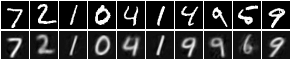

In [ ]:
n = 10
from torchvision.transforms.functional import to_pil_image
grid_orig = torchvision.utils.make_grid(xx_test[:n].reshape(-1,1,28,28), pad_value=1.0, padding=1, nrow=n, normalize=True)
grid_rec  = torchvision.utils.make_grid(yy_pred[:n].reshape(-1,1,28,28), pad_value=1.0, padding=1, nrow=n, normalize=True)
to_pil_image(torch.cat((grid_orig,grid_rec),dim=1))

## Imagens no plano 2D

In [ ]:
test_loader  = DataLoader(dataset_test, batch_size= len(dataset_test))
xx_train, yy_train = next(iter(test_loader))

In [ ]:
xx_train.dtype

torch.float32

In [ ]:
xin = xx_train.view(-1, 28*28)
encoded = trainer.model.encoder(xin)
encoded_data = encoded.data.cpu().numpy()

In [ ]:
encoded_data[:10,:]

array([[ 0.73289907,  2.3359506 ],
       [-0.95905507, -1.2462156 ],
       [-0.6973977 ,  0.30686262],
       [ 0.87190825, -2.1150422 ],
       [ 1.9290895 ,  0.13965827],
       [-0.86183727,  0.41384006],
       [ 0.73703825,  0.4114277 ],
       [ 3.1115832 ,  1.254734  ],
       [ 1.108431  , -0.24553443],
       [ 0.395099  ,  0.64067185]], dtype=float32)

In [ ]:
def i2show(classes_to_show):
    first = True
    for c in classes_to_show:
        if first:
            index = yy_train.numpy() == c
            first = False
        else:
            index |= yy_train.numpy() == c
    return index

In [ ]:
classes_to_show = np.arange(10)
index = i2show(classes_to_show)

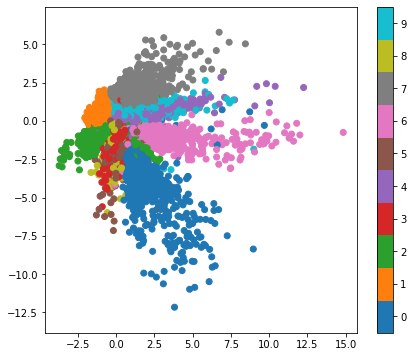

In [ ]:
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[index, 0], encoded_data[index, 1], 
            c=yy_train.numpy()[index], 
            cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

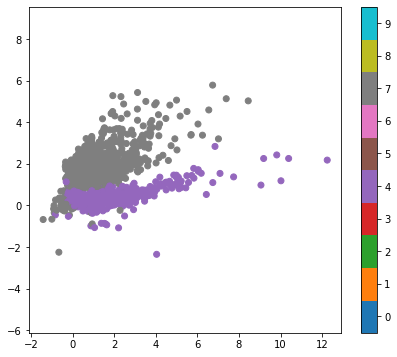

In [ ]:
classes_to_show = [7,4] #np.arange(10)
index = i2show(classes_to_show)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[index, 0], encoded_data[index, 1], 
            c=yy_train.numpy()[index], 
            cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

## Imagens geradas ao percorrer uma linha reta no espaço 2D

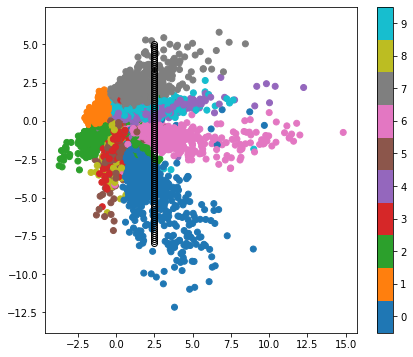

In [ ]:
n = 100
x = np.linspace(2.5,   2.5, n)
y = np.linspace(5., -8., n)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

In [ ]:
data = np.array([x, y]).T
data_in = torch.from_numpy(data).type(torch.FloatTensor)
    
out = trainer.model.decoder(data_in)
out = out.view(-1, 28, 28)

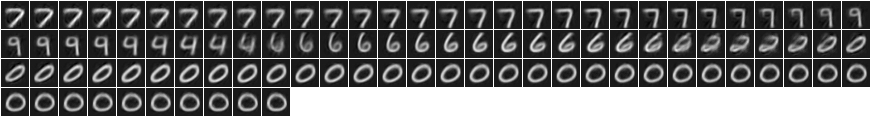

In [ ]:
grid  = torchvision.utils.make_grid(out[:n].reshape(-1,1,28,28), pad_value=1.0, padding=1, nrow=30, normalize=True)
to_pil_image(grid)

## Imagens geradas ao percorrer um círculo no espaço 2D centrado em (0,0)

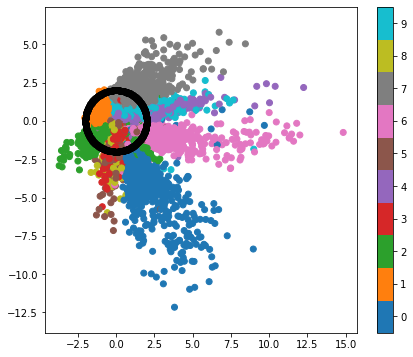

In [ ]:
n = 400
phi = np.linspace(-np.pi, np.pi, n)
r = 2.
x = r * np.cos(phi)
y = r * np.sin(phi)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

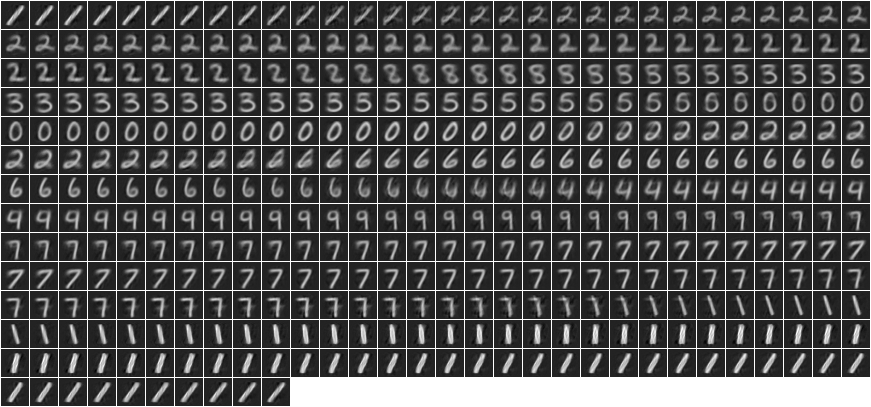

In [ ]:
data = np.array([x, y]).T
data_in = torch.from_numpy(data).type(torch.FloatTensor)
    
out = trainer.model.decoder(data_in)
out = out.view(-1, 28, 28)
grid  = torchvision.utils.make_grid(out[:n].reshape(-1,1,28,28), pad_value=1.0, padding=1, nrow=30, normalize=True)
to_pil_image(grid)

# Atividades

## Exercícios

1. Escolha um código (duas coordenadas no espaço 2D mostrado acima), e utilize o decoder (model.decoder) para mostrar qual é a saída correspondente da rede treinada.
2. Aumente o número de imagens geradas para 100 tanto ao percorrer uma linha reta como para percorrer um círculo,
   nos exemplos gerados acima e observe a melhora na interpolação entre as imagens geradas.
